In [15]:
import torch
from PIL import Image
from torchvision import transforms, models
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import sys

In [16]:
def load_checkpoint(filepath, device=None):
    """
    Load a ResNet-50 checkpoint for inference.
    """
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    # Load checkpoint (allow loading non-weights-only checkpoint)
    checkpoint = torch.load(filepath, map_location=device, weights_only=False)


    # Rebuild ResNet-50
    model = models.resnet50(pretrained=False)

    # Determine number of classes (support older checkpoints without 'num_classes')
    num_classes = checkpoint.get('num_classes', None)
    if num_classes is None:
        num_classes = len(checkpoint.get('class_to_idx', []))

    # Rebuild final fully connected layer
    model.fc = nn.Linear(
        model.fc.in_features,
        num_classes
    )

    # Load trained weights
    model.load_state_dict(checkpoint['model_state_dict'])

    # Restore class mapping
    model.class_to_idx = checkpoint['class_to_idx']

    model.to(device)
    model.eval()

    return model

In [17]:
import os
import json  # Added import for json module
import torch
from PIL import Image
from torchvision import transforms  # Added import for transforms

# Load the mapping file located next to this script
# Remove the extra quotes inside the string
cat_file = "/Users/monaverma/Documents/image classifiers/finetune_resnet/cat_to_name.json"

with open(cat_file, 'r') as f:
    cat_to_name = json.load(f)

# cat_file = os.path.join(os.path.dirname(__file__), 'cat_to_name.json')
# with open(cat_file, 'r') as f:
#     cat_to_name = json.load(f)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def process_image(image_path):
    """Scales, crops, and normalizes a PIL image for a PyTorch model."""
    image = Image.open(image_path).convert("RGB")

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    image = preprocess(image)
    return image

In [18]:
# Assistant
import os
import json  # Added import for json module
import torch
from PIL import Image
from torchvision import transforms  # Added import for transforms

# Load the mapping file located next to this script
# Remove the extra quotes inside the string
cat_file = "/Users/monaverma/Documents/image classifiers/finetune_resnet/cat_to_name.json"

with open(cat_file, 'r') as f:
    cat_to_name = json.load(f)

# cat_file = os.path.join(os.path.dirname(__file__), 'cat_to_name.json')
# with open(cat_file, 'r') as f:
#     cat_to_name = json.load(f)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def process_image(image_path):
    """Scales, crops, and normalizes a PIL image for a PyTorch model."""
    image = Image.open(image_path).convert("RGB")

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    image = preprocess(image)
    return image

In [19]:
def predict(image_path, model, topk=5):
    model.eval()
    image = process_image(image_path)
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        logps = model(image)
        # Convert logits to probabilities
        ps = torch.nn.functional.softmax(logps, dim=1)
        top_p, top_class = ps.topk(topk, dim=1)

    top_p = top_p.cpu().numpy().squeeze().tolist()
    top_class = top_class.cpu().numpy().squeeze().tolist()
    idx_to_class = {v : k for k, v in model.class_to_idx.items()}
    top_classes = [idx_to_class[i] for i in top_class]
    return top_p, top_classes

In [20]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    if title:
        ax.set_title(title)
    
    return ax

Top Probabilities: [0.9764562845230103, 0.007089782506227493, 0.0032826464157551527, 0.0025589545257389545, 0.001319668721407652]
Top Classes: ['43', '83', '89', '31', '72']
Top Flower Names: ['sword lily', 'hibiscus', 'watercress', 'carnation', 'azalea']


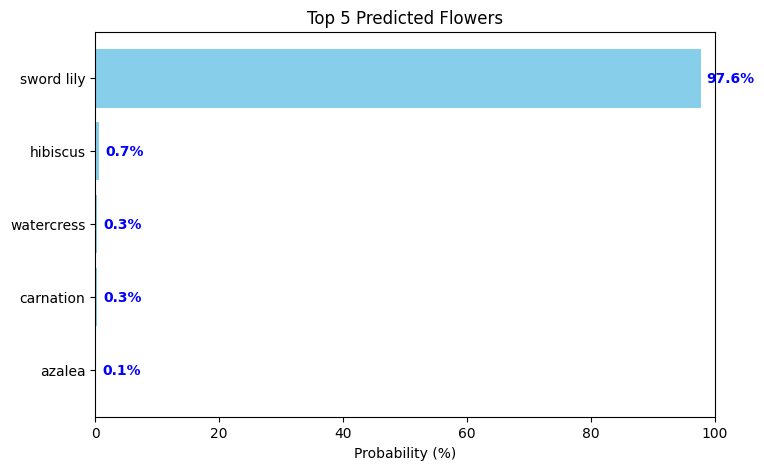

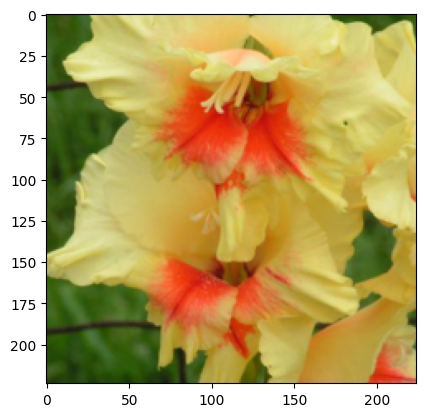

In [21]:
if __name__ == "__main__":

    # Plot top K predictions as a horizontal bar chart

    checkpoint_path = '/Users/monaverma/Documents/image classifiers/finetune_resnet/checkpoint_resnet_finetune.pth'  # Replace with your checkpoint path
    model = load_checkpoint(checkpoint_path)
    model.to(device)

    image_path = 'flower_data/test/43/image_02369.jpg'  # Replace with your image path

    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}\nPlease update `image_path` in resnet_predict.py to point to a valid image.")
        sys.exit(1)

    top_p, top_classes = predict(image_path, model, topk=5)

    # Map the top predicted class ids to human-readable names
    top_flower_names = [cat_to_name[cls] for cls in top_classes]

    print("Top Probabilities:", top_p)
    print("Top Classes:", top_classes)
    print("Top Flower Names:", top_flower_names)

# Convert probabilities to percentages
top_p_percent = [p * 100 for p in top_p]

plt.figure(figsize=(8,5))
plt.barh(top_flower_names[::-1], top_p_percent[::-1], color='skyblue')  # reverse to have highest on top
plt.xlabel('Probability (%)')
plt.title('Top 5 Predicted Flowers')
plt.xlim(0, 100)

# Show probability values on bars
for i, v in enumerate(top_p_percent[::-1]):
    plt.text(v + 1, i, f"{v:.1f}%", color='blue', va='center', fontweight='bold')

plt.show()
    
    # Display the image
image = process_image(image_path)
imshow(image)
plt.show()